In [1]:
from selenium import webdriver
import pandas as pd
import time
import itertools
import pprint
import json
import re
from IPython.display import display
from IPython.display import clear_output
from matplotlib import pyplot as plt
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [15, 7.5]

In [54]:
driver = webdriver.Chrome('/usr/bin/chromedriver')

# get all settlements links

In [65]:
driver.get('https://www.gov.il/he/departments/news/?OfficeId=104cb0f4-d65a-4692-b590-94af928c19c0&limit=10&topic=3ef9cac8-a1a9-4352-91d4-860efd3b720d&subTopic=626a30f9-8b50-495a-9b9f-e4ce4b433ca5')

In [66]:
settlements_url_list_of_lists = []
while True:
    series = pd.Series(driver.page_source.split(' '))
    settlements_url_list = series[series.str.contains('departments/news/') & ~series.str.contains('\?')].apply(lambda x: x[6:-1]).tolist()
    print('number of settlements:', len(settlements_url_list))
    settlements_url_list_of_lists.append(settlements_url_list)
    element = driver.find_elements_by_xpath("//div[contains(@class, 'button-gov blue xs-pl-5 xs-pr-5')]")[1]
    if element.is_displayed():
        element.click()
        time.sleep(0.25)
    else:
        break

number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10
number of settlements: 10


In [71]:
len(all_settlements_list)

280

In [74]:
all_settlements_list = list(itertools.chain.from_iterable(settlements_url_list_of_lists))
temp_settlements_series = pd.Series(all_settlements_list)
all_settlements_series = pd.Series(temp_settlements_series.unique())
display(all_settlements_series.shape)
display(all_settlements_series.head())

(210,)

0    https://www.gov.il/he/departments/news/hora-corona       
1    https://www.gov.il/he/departments/news/holon-corona      
2    https://www.gov.il/he/departments/news/bnei-brak-corona  
3    https://www.gov.il/he/departments/news/beer-sheva-corona 
4    https://www.gov.il/he/departments/news/um-el-paham-corona
dtype: object

In [76]:
all_settlements_csv_path = './all_settlements_links.csv'
all_settlements_series.to_csv(all_settlements_csv_path, index=False, header=False)
# all_settlements_series = pd.read_csv(all_settlements_csv_path, header=None)[0]
display(all_settlements_series.head())
display(all_settlements_series.shape)

0    https://www.gov.il/he/departments/news/hora-corona       
1    https://www.gov.il/he/departments/news/holon-corona      
2    https://www.gov.il/he/departments/news/bnei-brak-corona  
3    https://www.gov.il/he/departments/news/beer-sheva-corona 
4    https://www.gov.il/he/departments/news/um-el-paham-corona
dtype: object

(210,)

# get settlements datums

In [78]:
def get_settlement_data(driver):
    main_xpath = '//div[@class=\'margin-for-ul txt dark-gray-txt lg-mb-30 tbl-accesabilty tbl-responsive sub-links-permanent-underline\']//'
    xpath = f'{main_xpath}h3 | {main_xpath}h2 | {main_xpath}p | {main_xpath}li'
    elements_list = driver.find_elements_by_xpath(xpath)
    datum_list = [element.text for element in elements_list]
    b = pd.Series(datum_list)
    datum_clean_list = b[:b[b.str.contains('הנחיות לציבור')].index[0]].tolist()
    return datum_clean_list

In [79]:
all_settlements_dict = {}

for index, settlement_link in enumerate(all_settlements_series):        
    driver.get(settlement_link)
    time.sleep(0.25)
    clear_output(wait=True) 
    settlement_datum_list = get_settlement_data(driver)
    all_settlements_dict[settlement_link] = {'title': driver.title, 'datum': settlement_datum_list}    
    print(f'{index + 1} / {len(all_settlements_series)}: {settlement_link}')
    print(all_settlements_dict[settlement_link])

210 / 210: https://www.gov.il/he/departments/news/kiryat-shmona-corona
{'title': 'קריית שמונה - מקומות שבהם שהו חולי קורונה | משרד הבריאות', 'datum': ['מקומות שבהם שהו חולי קורונה מאומתים בקריית שמונה', 'תאריך עדכון 11/04/2020', '2.4.20, 10:35-10:50 - סופר פארם , מתחם ביג, קרית שמונה', '2.4.20, 9:40-10:05 - סופר-פוד מרקט, קניון 8 סנטר, קרית שמונה', '2.4.20, 9:20-9:40 - Be פארם , קניון 8 סנטר, קרית שמונה', '2.4.20, 9:00-10:20 - קניון 8 סנטר, קומה ראשונה, קרית שמונה', '30.3.20, 13:50-14:05 - שופר סל דיל מתחם ביג, קרית שמונה', '30.3.20, 13:40-13:50 - סופר פארם מתחם ביג, קרית שמונה', 'תאריך עדכון 05/04/2020', '23.3.2020 16:00 - 17:00 תחנת דלק YELLOW', '8.3 בשעות 19:00- 19:30 סופר פארם ביג קרית שמונה.']}


In [80]:
json_path = 'all_settlements_dict.json'
with open(json_path, 'w') as fp:
    json.dump(all_settlements_dict, fp)
# with open(json_path, 'r') as fp:
#     all_settlements_dict = json.load(fp)

# extract incident date

In [81]:
def get_update_date_if_update(row):
    if 'עדכון' in re.findall('עדכון|עודכן', row['raw']):
        return get_date_from_string(row['raw'])
    else:
        return None

In [82]:
def get_date_from_string(string):
    date_strings_list = re.findall('\d{1,2}\.\d{1,2}\.\d{1,4}|\d{1,2}/\d{1,2}/\d\d', string)
    if date_strings_list:
        if date_strings_list[0] == '30.30.2020':
            date_strings_list[0] = '30.3.2020'        
#         print(string, date_strings_list[0])
        date = pd.to_datetime(date_strings_list[0], dayfirst=True)
    else:
        date_strings_list_2 = re.findall('\d{1,2}\.\d{1,2}', string)
        if date_strings_list_2:
            if date_strings_list_2[0] == '24.32':
                date_strings_list_2[0] = '24.3'
            date = pd.to_datetime(date_strings_list_2[0] + '.20', dayfirst=True)
        else:
            date = None
    return date

In [83]:
def get_settlement_df(settlement_link, settlement_dict):
    settlement_name = " ".join(settlement_dict['title'].split()[:-9])
    df = pd.Series(settlement_dict['datum']).to_frame('raw')
    df['update_date_temp'] = df.apply(get_update_date_if_update, axis=1)
    df['update_date'] = df['update_date_temp'].ffill()
    clean_df = df[~df['update_date_temp'].notna()][['raw', 'update_date']].dropna(subset=['update_date'])
    clean_df['incident_day'] = clean_df['raw'].apply(get_date_from_string)
    clean_df['settlement_name'] = settlement_name
    clean_df['settlement_link'] = settlement_link
    return clean_df

In [84]:
temp_df = [get_settlement_df(key, value) for key, value in all_settlements_dict.items()]
incidents_df = pd.concat(temp_df).reset_index(drop=True)
incidents_df.head()

,raw,update_date,incident_day,settlement_name,settlement_link
0,"26/04/2020 14:00 - 15:00 מרפאת שירותי בריאות כללית חורה. , חורה",2020-04-28,2020-04-26,חורה,https://www.gov.il/he/departments/news/hora-corona
1,"19/04/2020 17:30 - 18:00 קופח לאומית א , חורה",2020-04-28,2020-04-19,חורה,https://www.gov.il/he/departments/news/hora-corona
2,"19/04/2020 17:30 - 18:00 קופת חולים לאומית א , חורה",2020-04-28,2020-04-19,חורה,https://www.gov.il/he/departments/news/hora-corona
3,"23/04/2020 08:30 - 9:00 קופת חולים כללית , חורה",2020-04-27,2020-04-23,חורה,https://www.gov.il/he/departments/news/hora-corona
4,"22/04/2020 09:00 - 11:00 דואר , חורה",2020-04-27,2020-04-22,חורה,https://www.gov.il/he/departments/news/hora-corona


In [93]:
all_settlements_links_series = pd.Series(list(all_settlements_dict.keys()))
all_settlements_links_series.head()

0    https://www.gov.il/he/departments/news/hora-corona       
1    https://www.gov.il/he/departments/news/holon-corona      
2    https://www.gov.il/he/departments/news/bnei-brak-corona  
3    https://www.gov.il/he/departments/news/beer-sheva-corona 
4    https://www.gov.il/he/departments/news/um-el-paham-corona
dtype: object

In [99]:
all_settlements_links_set = set(all_settlements_links_series)
incidents_settlement_links_set = set(incidents_df['settlement_link'])

In [100]:
all_settlements_links_set.difference(incidents_settlement_links_set)

{'https://www.gov.il/he/departments/news/dvira-corona',
 'https://www.gov.il/he/departments/news/ein-hanatziv-corona',
 'https://www.gov.il/he/departments/news/givat-yearim-corona',
 'https://www.gov.il/he/departments/news/kfar-monash-corona',
 'https://www.gov.il/he/departments/news/leavim-corona',
 'https://www.gov.il/he/departments/news/magal-corona',
 'https://www.gov.il/he/departments/news/misgav-corona',
 'https://www.gov.il/he/departments/news/mitzpe-hoshaya-corona',
 'https://www.gov.il/he/departments/news/nof-haemek-corona',
 'https://www.gov.il/he/departments/news/ora-corona',
 'https://www.gov.il/he/departments/news/yadbinyamin-corona'}

In [14]:
incidents_df[incidents_df['incident_day'] == '2020-04-29']

,raw,update_date,incident_day,settlement_name,settlement_link
9448,29.4.2020 19:00 - 20:00 מחסני השוק מיתרים,2020-04-05,2020-04-29,שמעה,https://www.gov.il/he/departments/news/shomaa-corona


In [15]:
incidents_df[incidents_df['incident_day'] == '2020-01-04']

,raw,update_date,incident_day,settlement_name,settlement_link
5892,4/1/2020 8:00 - 8:30 פיצה שמש רח' תרצה,2020-04-05,2020-01-04,רמת גן,https://www.gov.il/he/departments/news/ramat-gan-corona
5893,4/1/2020 8:00 - 8:30 מאור הפיצה רח' אריה בן אליעזר 24,2020-04-05,2020-01-04,רמת גן,https://www.gov.il/he/departments/news/ramat-gan-corona
8340,4/1/2020 9:30 - 18:00 הוסטל בית גיא רח' פנחס בן דוד 5,2020-04-05,2020-01-04,ראשון לציון,https://www.gov.il/he/departments/news/-rishon-lezion-corona


In [101]:
incidents_csv_path = './incidents.csv'
incidents_df.to_csv(incidents_csv_path, index=False)
# incidents_df = pd.read_csv(incidents_csv_path, parse_dates=['update_date', 'incident_day']).dropna()
incidents_df.head()

,raw,update_date,incident_day,settlement_name,settlement_link
0,"26/04/2020 14:00 - 15:00 מרפאת שירותי בריאות כללית חורה. , חורה",2020-04-28,2020-04-26,חורה,https://www.gov.il/he/departments/news/hora-corona
1,"19/04/2020 17:30 - 18:00 קופח לאומית א , חורה",2020-04-28,2020-04-19,חורה,https://www.gov.il/he/departments/news/hora-corona
2,"19/04/2020 17:30 - 18:00 קופת חולים לאומית א , חורה",2020-04-28,2020-04-19,חורה,https://www.gov.il/he/departments/news/hora-corona
3,"23/04/2020 08:30 - 9:00 קופת חולים כללית , חורה",2020-04-27,2020-04-23,חורה,https://www.gov.il/he/departments/news/hora-corona
4,"22/04/2020 09:00 - 11:00 דואר , חורה",2020-04-27,2020-04-22,חורה,https://www.gov.il/he/departments/news/hora-corona


# statistics

In [102]:
incidents_stat_df = incidents_df.groupby('incident_day').size().to_frame('size').reset_index()

In [103]:
incidents_clean_stat_df = incidents_stat_df[(incidents_stat_df['incident_day'] >= '2020-03-01') & (incidents_stat_df['incident_day'] <= '2020-04-28')]
incidents_clean_stat_df.tail(5)

,incident_day,size
59,2020-04-23,13
60,2020-04-24,12
61,2020-04-25,3
62,2020-04-26,4
63,2020-04-27,1


Text(0, 0.5, 'number of incidents')

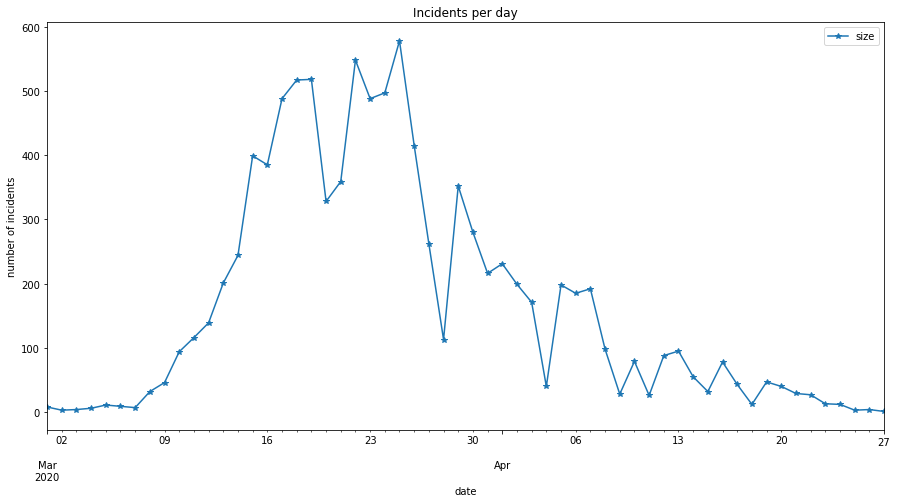

In [104]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7.5]
incidents_clean_stat_df.plot(x='incident_day', y='size', marker='*')
plt.title('Incidents per day')
plt.xlabel('date')
plt.ylabel('number of incidents')

# Cities

In [105]:
def check_name(df, name):
    settlement_names_series = df['settlement_name']
    return settlement_names_series[settlement_names_series.str.contains(name)].unique()

In [106]:
def show_stat(df, settlement_name):
    print(check_name(df, settlement_name))
    settlement_df = df[df['settlement_name'].str.contains(settlement_name)]
    stat_df = settlement_df.groupby('incident_day').size().to_frame('size').reset_index()
    stat_df.plot(x='incident_day', y='size', marker='*')
    plt.title('Incidents per day')
    plt.xlabel('date')
    plt.ylabel('number of incidents')

['בני ברק']


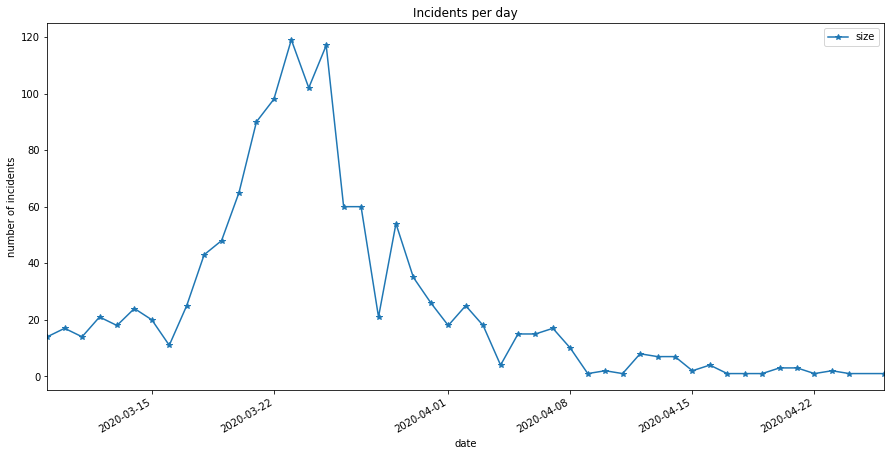

In [107]:
show_stat(incidents_df, 'בני ברק')

['פתח תקווה (פתח תקוה)']


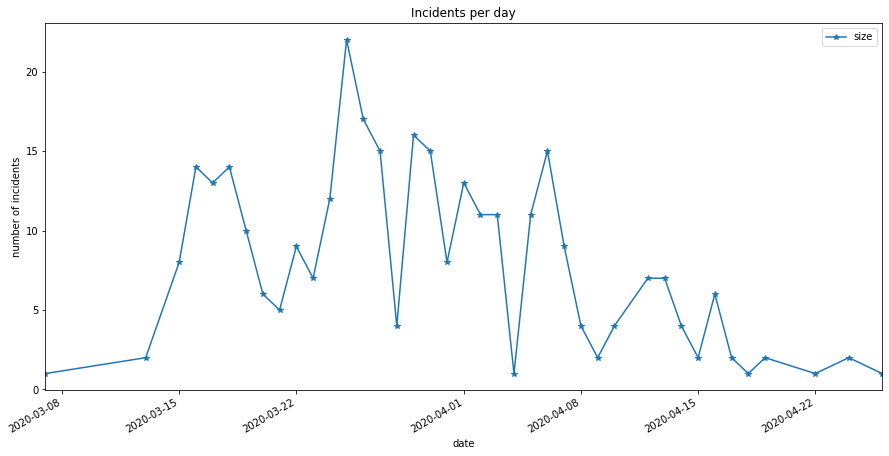

In [108]:
show_stat(incidents_df, 'פתח')

In [109]:
show_stat(incidents_df, 'כפר סבא')

[]


TypeError: no numeric data to plot

['תל אביב -']


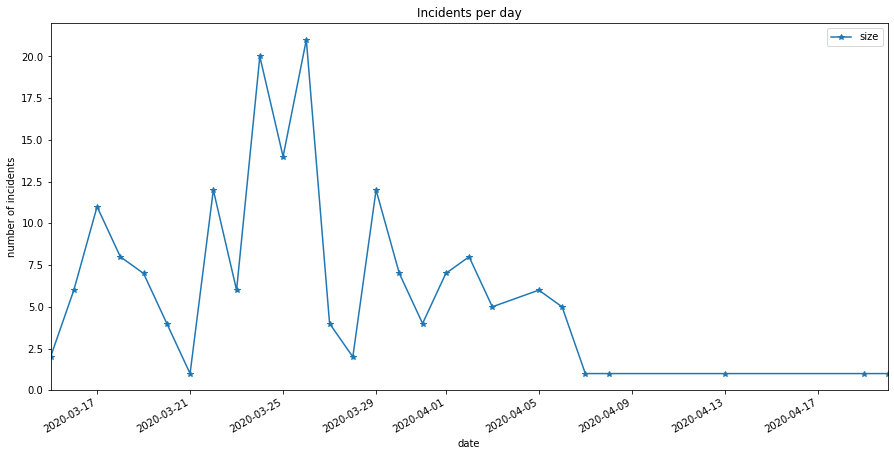

In [110]:
show_stat(incidents_df, 'תל אביב')

['ירושלים והסביבה']


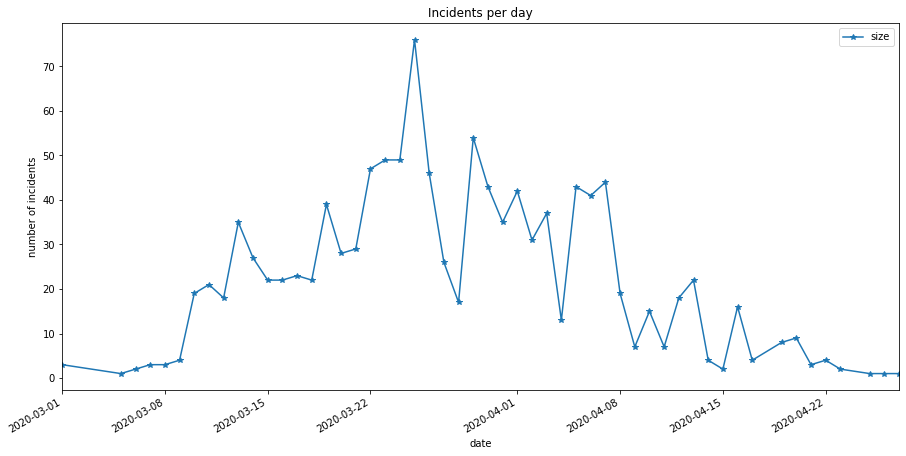

In [111]:
show_stat(incidents_df, 'ירושלים')

['חיפה']


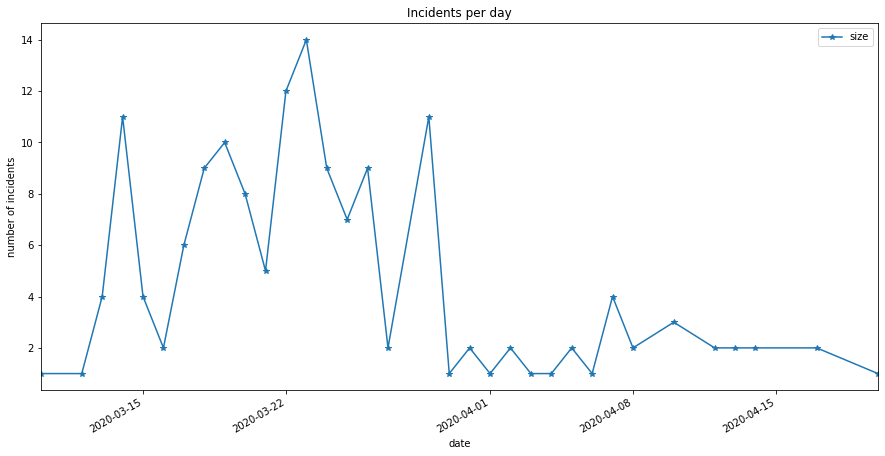

In [112]:
show_stat(incidents_df, 'חיפה')

In [113]:
incidents_df['incident_to_update_days_delay'] = incidents_df['update_date'] - incidents_df['incident_day']
incidents_df.head()

,raw,update_date,incident_day,settlement_name,settlement_link,incident_to_update_days_delay
0,"26/04/2020 14:00 - 15:00 מרפאת שירותי בריאות כללית חורה. , חורה",2020-04-28,2020-04-26,חורה,https://www.gov.il/he/departments/news/hora-corona,2 days
1,"19/04/2020 17:30 - 18:00 קופח לאומית א , חורה",2020-04-28,2020-04-19,חורה,https://www.gov.il/he/departments/news/hora-corona,9 days
2,"19/04/2020 17:30 - 18:00 קופת חולים לאומית א , חורה",2020-04-28,2020-04-19,חורה,https://www.gov.il/he/departments/news/hora-corona,9 days
3,"23/04/2020 08:30 - 9:00 קופת חולים כללית , חורה",2020-04-27,2020-04-23,חורה,https://www.gov.il/he/departments/news/hora-corona,4 days
4,"22/04/2020 09:00 - 11:00 דואר , חורה",2020-04-27,2020-04-22,חורה,https://www.gov.il/he/departments/news/hora-corona,5 days


In [114]:
incidents_df['incident_to_update_days_delay'].describe()

count    9703                    
mean     0 days 20:24:21.815933  
std      240 days 13:02:12.924489
min      -6571 days +00:00:00    
25%      7 days 00:00:00         
50%      10 days 00:00:00        
75%      12 days 00:00:00        
max      92 days 00:00:00        
Name: incident_to_update_days_delay, dtype: object

In [115]:
incidents_df.loc[incidents_df['incident_to_update_days_delay'].idxmin()]

raw                              23/03/2020 08:00- 08:00, סופר סל , אופקים           
update_date                      2002-03-27 00:00:00                                 
incident_day                     2020-03-23 00:00:00                                 
settlement_name                  אופקים                                              
settlement_link                  https://www.gov.il/he/departments/news/ofakim-corona
incident_to_update_days_delay    -6571 days +00:00:00                                
Name: 8757, dtype: object

In [116]:
incidents_df.loc[incidents_df['incident_to_update_days_delay'].idxmax()]

raw                              4/1/2020 8:00  - 8:30 פיצה שמש רח' תרצה                
update_date                      2020-04-05 00:00:00                                    
incident_day                     2020-01-04 00:00:00                                    
settlement_name                  רמת גן                                                 
settlement_link                  https://www.gov.il/he/departments/news/ramat-gan-corona
incident_to_update_days_delay    92 days 00:00:00                                       
Name: 5892, dtype: object

Text(0, 0.5, 'count')

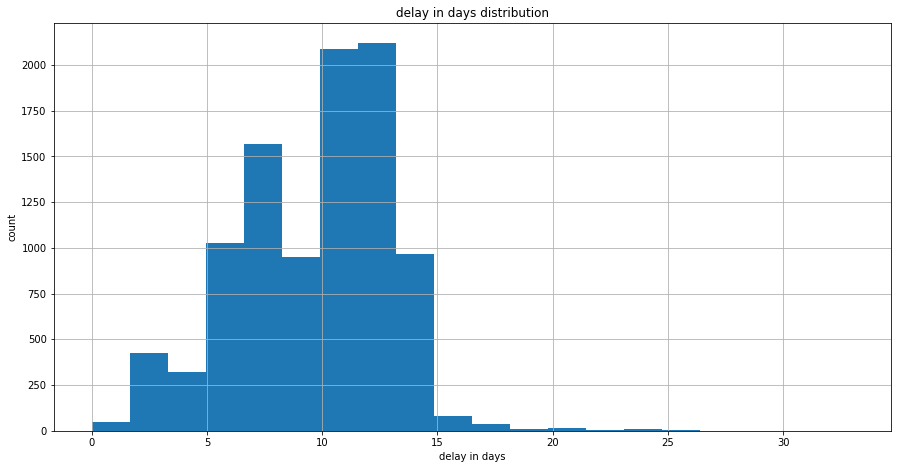

In [117]:
a = incidents_df['incident_to_update_days_delay'].dt.days
b = a[(a >= 0) & (a < 50)]
b.hist(bins=20)
plt.title('delay in days distribution')
plt.xlabel('delay in days')
plt.ylabel('count')

In [118]:
c = incidents_df.groupby('incident_day')['incident_to_update_days_delay'].apply(lambda x: x.mean()).reset_index()
c['incident_to_update_days_delay'] = c['incident_to_update_days_delay'].dt.days
c.head()

,incident_day,incident_to_update_days_delay
0,2020-01-04,92
1,2020-02-19,33
2,2020-02-24,29
3,2020-02-27,25
4,2020-02-28,24


In [119]:
d = c['incident_to_update_days_delay']
e = c[(d < 50) & (d >= 0)]
e.head()

,incident_day,incident_to_update_days_delay
1,2020-02-19,33
2,2020-02-24,29
3,2020-02-27,25
4,2020-02-28,24
5,2020-02-29,25


Text(0, 0.5, 'average delay in days')

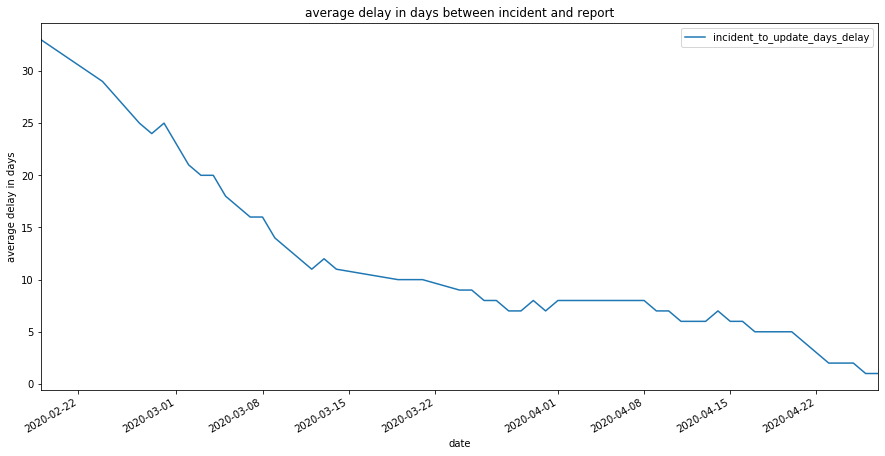

In [120]:
e.plot(x='incident_day', y='incident_to_update_days_delay')
plt.title('average delay in days between incident and report')
plt.xlabel('date')
plt.ylabel('average delay in days')